## Creating a simple single-cell simulation, using new tools
First we make some imports from the ateam package, and create a SimManager for a new simulation.

This will give us a basic config file to work from, and place it in a new folder.

In [1]:
from ateam.sim.setup import SimManager
import numpy as np
%matplotlib inline

# Specify the sim folder and a template file
new_config = '/allen/aibs/mat/tmchartrand/bmtk_networks/temp/batch_config.json'
config_template = "/allen/aibs/mat/tmchartrand/bmtk_networks/biophys_components_shared/default_config.json"

sm = SimManager.from_template(config_template=config_template, overwrite=True, config_path=new_config)

Here is one way we could get more info about this function (you can also see this in a pop-up by pressing shift-tab inside a function call.

In [2]:
help(SimManager.from_template)

Help on method from_template in module ateam.sim.setup.sim_manager:

from_template(cls, config_template, config_file='config.json', sim_folder=None, config_path=None, overwrite=False) method of __builtin__.type instance
    Create a SimManager from template config file in a new simulation folder.
    Creates folder if it doesn't exist.



### Where to store shared simulation files?
In my personal config template, I define the basic properties that I want fixed across many different simulations (dt, spike_threshold, etc). 

I also refer to a shared components directory that sits on the network, so I can download all my morphology and params files to that location, and work from a single copy of the modfiles also. This isn't necessary for the rest of the code to work. If others use this approach, though, we could share a single components directory across the group.

For now, I could also set `"biophysical_neuron_models_dir": "/allen/aibs/mat/ateam_shared/All_active_params"` to use Ani's results directly.

```
{
  "manifest": {
    "$OUTPUT_DIR": "$BASE_DIR/output", 
    "$BASE_DIR": ".", 
    "$COMPONENTS_DIR": "/allen/aibs/mat/tmchartrand/bmtk_networks/biophys_components_shared", 
    "$NETWORK_DIR": "$BASE_DIR/network"
  }, 
  "target_simulator": "NEURON", 
  "run": {
    "nsteps_block": 5000, 
    "dt": 0.1, 
    "dL": 20.0, 
    "spike_threshold": -20.0, 
    "tstop": 500.0
  }, 
  "conditions": {
    "celsius": 34.0, 
    "v_init": -80.0
  },
  "components": {
    "point_neuron_models_dir": "$COMPONENTS_DIR/point_neuron_templates", 
    "biophysical_neuron_models_dir": "$COMPONENTS_DIR/biophysical_neuron_templates", 
    "mechanisms_dir": "$COMPONENTS_DIR/mechanisms", 
    "morphologies_dir": "$COMPONENTS_DIR/morphologies", 
    "synaptic_models_dir": "$COMPONENTS_DIR/synaptic_models"
  }, 
  "output": {
    "spikes_file_csv": "spikes.csv", 
    "spikes_file": "spikes.h5", 
    "log_file": "log.txt", 
    "output_dir": "${OUTPUT_DIR}", 
    "overwrite_output_dir": true
  }
}
```

I could then use the info in this template config to download (and rename) all morphology files I need to the right location as a batch:

In [11]:
from ateam.data.allensdk_tools import download_morph_files, download_models_to_config

cell_list = [525133308]
# Download morphology and perisomatic model params:
download_models_to_config(cell_list, config_template, model_type='peri')

# or just download morphology:
morph_dir = "/allen/aibs/mat/tmchartrand/bmtk_networks/biophys_components_shared/morphologies"
download_morph_files(cell_list, morph_dir)

2019-02-13 11:24:53,385 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/626185205
2019-02-13 11:24:53,494 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/667327859


### Adding nodes and input to the simulation

Then we define properties for our nodes and edges

In [3]:

cell_id = 525133308
node_props = {
        'cell_name': cell_id,
        'morphology': '{}.swc'.format(cell_id),
        'dynamics_params': 'optim_param_{}.json'.format(cell_id),
        'model_type': 'biophysical',
        'model_template': 'ctdb:Biophys1.hoc',
        'model_processing': 'aibs_allactive_ani'
    }

edge_props = {
    'nsyns': 100,
    'syn_weight': 1e-5, 
    'distance_range_min': 0,
    'distance_range_max': 200,
    'delay': 0,
    'target_sections': ['somatic'],
    'dynamics_params': 'AMPA_ExcToExc.json',
    'model_template': 'exp2syn'
}


Rather than call BMTK's NetworkBuilder directly, SimManager can create networks for us and keep track of saving the appropriate files.

(Comments show extra BMTK code that SimManager takes care of.)

In [4]:
net = sm.new_network('single')
# net = NetworkBuilder('single')
net.add_nodes(N=1, **node_props)
# net.build()
# net.save()

virt_net = sm.new_network('input')
# virt_net = NetworkBuilder(name)
virt_net.add_nodes(N=1, model_type='virtual')
virt_net.add_edges(source=virt_net.nodes(), target=net.nodes(), **edge_props)
# virt_net.build()
# virt_net.save()

# This takes care of generating a new spike input file and adding the path to the config
sm.write_spikeinput_poisson(virt_net.name, rate=100)

sm.add_membrane_report()

sm.save_network_files()

Message: building edges


## Then we simulate:
- Calls the standard run_bionet.py script, but no need to copy that to the sim directory or to cd to the directory

In [10]:
sm.run_bionet()

# Could also use MPI if we had a larger net to simulate:
# sm.run_bionet_mpi(ncores=4)

/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_module'
NEURON -- VERSION 7.5 master (6b4c19f) 2017-09-25
Duke, Yale, and the BlueBrain Project -- Copyright 1984-2016
See http://neuron.yale.edu/neuron/credits

Additional mechanisms from files
 modfiles/CaDynamics.mod modfiles/Ca_HVA.mod modfiles/Ca_LVA.mod modfiles/Ih.mod modfiles/Im.mod modfiles/Im_v2.mod modfiles/Kd.mod modfiles/K_P.mod modfiles/K_Pst.mod modfiles/K_T.mod modfiles/K_Tst.mod modfiles/Kv2like.mod modfiles/Kv3_1.mod modfiles/Nap_Et2.mod modfiles/Nap.mod modfiles/NaTa.mod modfiles/NaTa_t.mod modfiles/NaTg.mod modfiles/NaTs2_t.mod modfiles/NaTs.mod modfiles/NaV.mod modfiles/SK.mod modfiles/vecevent.mod

numprocs=4
2019-02-13 11:43:14,691 [INFO] Created log file
2019-02-13 11:43:14,716 [INFO] Running NEURON with mpi (4 cores).
2019-02-13 11:43:14,898 [INFO] Building cells.
2019-02-13 11:43:15,058 [INFO] Building recurrent connections
2019-02-13 1

We can call plotting functions from the config path, using that to find the correct sim output files. The plotting functions need work, please contribute!

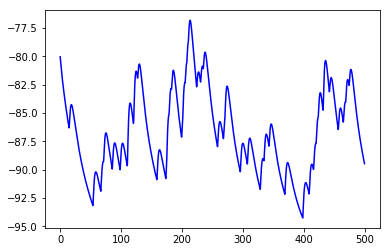

In [11]:
from ateam.analysis.cell_vars import plot_v
plot_v(sm.config_path)

## Loading existing simulations
We can use SimManager to load and then modify or duplicate an existing simulation

In [18]:
config_path = '/allen/aibs/mat/tmchartrand/bmtk_networks/temp/batch_config.json'
sm = SimManager(config_path)

These functions duplicate the entire sim folder (clearing the output), and update the node types file for the simple case when only a single type is present

In [15]:
folder = '/allen/aibs/mat/tmchartrand/bmtk_networks/temp/new_sim/'
sm_new = sm.save_copy(folder, overwrite=True)

# Define the node props we want to change (probably those that are cell-specific)
node_props = {
            'cell_name': cell_id,
            'morphology': '{}.swc'.format(cell_id),
            'dynamics_params': 'optim_param_{}.json'.format(cell_id)
}
# We need to know what we named the network to change:
net_name = 'single'
sm_new.update_node_type_props(net_name, node_props)

If we wanted to modify the network in more depth, we can load it more fully, allowing us to add edges to existing nodes:

Details to come on this...